In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA


sns.set_theme(style="darkgrid")

In [3]:
data = load_all_locations()

In [4]:
def create_time_features(df):
    df['hour'] = df.time.dt.hour
    df['dayofmonth'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    return df

In [5]:
X, y = data[0].copy(), data[1].copy()


# One-hot Encoding
X = X.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X["location"]).astype(int)
X = X.drop("location", axis=1)
X = pd.merge(X, one_hot, left_index=True, right_index=True)

# Add time based features
X = create_time_features(X)

# Drop datetime
X = X.drop(columns=["time"])

# Drop missing column values
nan_columns = X.columns[X.isna().any()].tolist()
X = X.drop(columns=nan_columns)

X.shape, y.shape


((81118, 53), (81118, 4))

In [6]:
X_train = X[X.set_type == "TRAIN"].copy().drop(columns=["set_type"])
y_train = y[y.set_type == "TRAIN"].copy()["y"]

# X_test = X[(X.set_type == "TEST")].copy().drop(columns=["set_type"])
# y_test = y[(y.set_type == "TEST")].copy()["y"]
X_test = X[(X.set_type == "TEST") & (X.A == True)].copy().drop(columns=["set_type"])
y_test = y[(y.set_type == "TEST") & (y.location == "A")].copy()["y"]

In [7]:
pca = PCA(n_components=20)
pca.fit(X_train)


PCA(n_components=20)

In [8]:
pca.get_feature_names_out(X_train.columns)

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19'], dtype=object)

In [9]:
pca.transform(X_train)

array([[-6.42227075e+05,  3.10830152e+04,  1.32652440e+04, ...,
         2.61521517e+00, -4.18855492e-01, -3.41307955e+00],
       [-6.42241929e+05,  3.09247321e+04,  1.37414990e+04, ...,
         2.21080374e+00,  1.68404330e+01, -3.05794205e+00],
       [-6.42287221e+05,  3.04420390e+04,  1.51938344e+04, ...,
         2.25775536e+00, -1.13593229e+00, -4.55031065e+00],
       ...,
       [-5.83748612e+05,  7.27105446e+03, -1.09006332e+04, ...,
        -2.31629777e+00, -1.38188925e-01,  1.01808757e+00],
       [-6.41504012e+05,  3.02578720e+04,  1.21484224e+04, ...,
        -2.75849288e+00, -4.40900128e-01,  5.04058882e-01],
       [-6.42261489e+05,  3.07162505e+04,  1.43687834e+04, ...,
        -3.14089420e+00, -6.08807330e-01, -2.25098460e-01]])

In [10]:


model = xgb.XGBRegressor(
    max_depth=7,
    colsample_bytree=0.8,
    eta=0.1,
    n_estimators=90,
    reg_alpha=0.01,
    reg_lambda=0.01
)

model.fit(pca.transform(X_train), y_train)

prediction = model.predict(pca.transform(X_test))

In [11]:
print(
    "MAE: ",
    round(
        mean_absolute_error(
            y_true=y_test,
            y_pred=prediction,
        ),
        3,
    ),
)

MAE:  177.122


In [12]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())

,y
0,0.00
1,0.00
2,0.00
3,0.00
4,19.36
...,...
81113,50.96
81114,2.94
81115,0.00
81116,-0.00


In [22]:
pd.merge(X, y.reset_index()[["y"]], left_index=True, right_index=True).set_type


0        TRAIN
1        TRAIN
2        TRAIN
3        TRAIN
4        TRAIN
         ...  
81113     TEST
81114     TEST
81115     TEST
81116     TEST
81117     TEST
Name: set_type, Length: 81118, dtype: object

In [25]:
corr = pd.merge(X.drop(columns=["set_type"]), y.reset_index()[["y"]], left_index=True, right_index=True).corr()
corr.style.background_gradient(cmap='coolwarm')

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,A,B,C,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear,y
absolute_humidity_2m:gm3,1.000000,-0.797667,0.342530,0.339913,0.162510,0.974646,0.267138,0.272781,0.226694,0.230325,0.053718,0.009689,-0.114622,-0.075472,-0.139274,-0.084636,-0.095913,0.289887,-0.306621,0.099918,0.086340,-0.010718,0.117493,0.107005,-0.096635,0.279810,0.185712,0.096543,-0.154599,-0.004788,-0.022194,0.057079,0.024446,0.402335,0.145832,0.892073,0.072234,-0.191198,-0.128965,0.088891,-0.238462,0.006774,0.039051,-0.053179,0.012609,0.018523,0.059979,-0.002000,0.264331,0.262956,-0.204962,0.266106,0.199171
air_density_2m:kgm3,-0.797667,1.000000,-0.454448,-0.443340,-0.112623,-0.829897,-0.380268,-0.393433,-0.365406,-0.380832,-0.104438,-0.046697,0.063464,0.047951,0.075682,0.052706,0.057512,-0.367647,0.383751,0.334644,-0.106025,-0.029135,0.320751,0.331977,0.128154,-0.176642,0.101812,0.343113,0.174987,0.003358,0.003523,-0.086678,-0.073033,-0.467357,-0.088518,-0.905755,-0.134777,0.019728,-0.057469,-0.006161,0.112139,0.027404,0.001507,0.043796,-0.048230,-0.046287,-0.040019,-0.000084,-0.197253,-0.199345,0.223562,-0.201289,-0.282037
clear_sky_energy_1h:J,0.342530,-0.454448,1.000000,0.992363,-0.043518,0.346377,0.911662,0.921665,0.735991,0.747232,-0.008477,0.006158,-0.053826,-0.045768,-0.063465,-0.050478,-0.053626,0.664948,-0.718248,0.138862,-0.009571,-0.032371,0.143125,0.137060,-0.083192,0.048986,-0.341702,0.131002,-0.060748,-0.003585,-0.002845,-0.038716,0.057392,0.836928,0.015186,0.429838,-0.002442,0.061531,0.015661,0.069224,-0.351658,0.017548,0.007851,-0.014792,0.006892,-0.004818,0.013003,-0.000153,-0.070381,-0.067548,-0.049776,-0.068353,0.608110
clear_sky_rad:W,0.339913,-0.443340,0.992363,1.000000,-0.042952,0.343509,0.917569,0.913827,0.743451,0.743180,-0.008211,0.006037,-0.051816,-0.045290,-0.063206,-0.049363,-0.052028,0.665756,-0.722070,0.139501,-0.010307,-0.032157,0.143458,0.137542,-0.082511,0.047770,-0.316726,0.131632,-0.060447,-0.003575,-0.003309,-0.040133,0.002487,0.840508,0.015832,0.415603,-0.002622,0.052830,0.005475,0.064420,-0.337018,0.016167,0.007931,-0.014764,0.006773,-0.051700,0.013010,0.000029,-0.070103,-0.067288,-0.049675,-0.068089,0.617149
dew_or_rime:idx,0.162510,-0.112623,-0.043518,-0.042952,1.000000,0.167412,-0.043747,-0.044937,-0.030684,-0.031247,0.035623,-0.006036,-0.041339,-0.033026,-0.041314,-0.034856,-0.040249,-0.053515,0.053811,0.009233,0.007966,0.001528,0.013442,0.011933,-0.410747,0.031849,0.093728,0.010433,-0.013326,-0.000371,-0.003013,0.016888,-0.027381,-0.027096,0.016465,0.135492,0.034861,-0.068485,-0.063858,-0.009681,-0.007979,0.000193,0.019332,-0.015775,-0.004969,-0.010317,0.008278,-0.011562,0.090531,0.081971,-0.023335,0.082601,-0.026433
dew_point_2m:K,0.974646,-0.829897,0.346377,0.343509,0.167412,1.000000,0.274947,0.280784,0.228254,0.232325,0.094709,0.024293,-0.118608,-0.080038,-0.143488,-0.089151,-0.100298,0.291963,-0.308673,0.088265,0.085492,-0.007010,0.105114,0.094242,-0.094443,0.253205,0.191798,0.083401,-0.199528,-0.004721,-0.017296,0.071742,0.025955,0.405658,0.176265,0.907572,0.110818,-0.220433,-0.084448,0.127628,-0.221159,0.007723,0.025272,-0.051970,0.026813,0.019390,0.072714,-0.005120,0.286703,0.283818,-0.216074,0.287996,0.202230
diffuse_rad:W,0.267138,-0.380268,0.911662,0.917569,-0.043747,0.274947,1.00

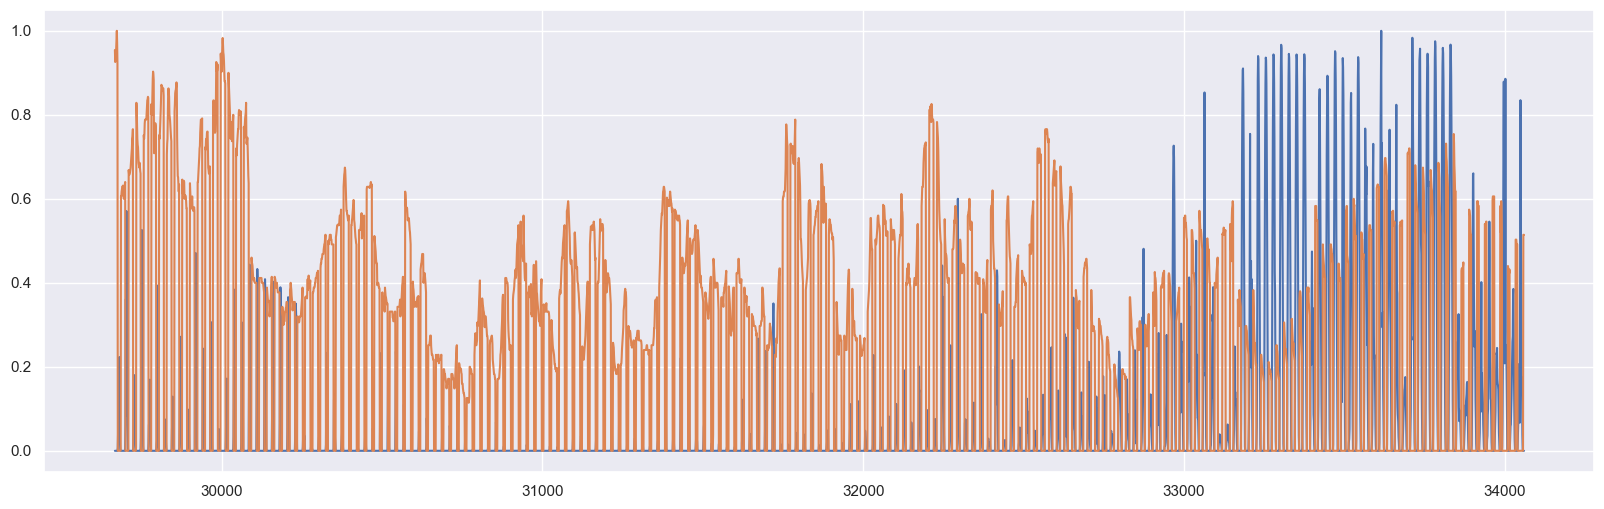

In [60]:
fig, ax = plt.subplots(figsize=(20, 6))

plt.plot(y_test.index, normalize(y_test))
# plt.plot(y_test.index, normalize(prediction))
# plt.plot(y_test.index, normalize(X_test["clear_sky_energy_1h:J"]))
# plt.plot(y_test.index, normalize(X_test["direct_rad:W"]))
plt.plot(y_test.index, normalize((X_test["absolute_humidity_2m:gm3"]) / (1+ X_test["clear_sky_energy_1h:J"])))
# plt.plot(y_test.index, normalize(X_test["clear_sky_energy_1h:J"]) * (1 - normalize((X_test["effective_cloud_cover:p"])**2)))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

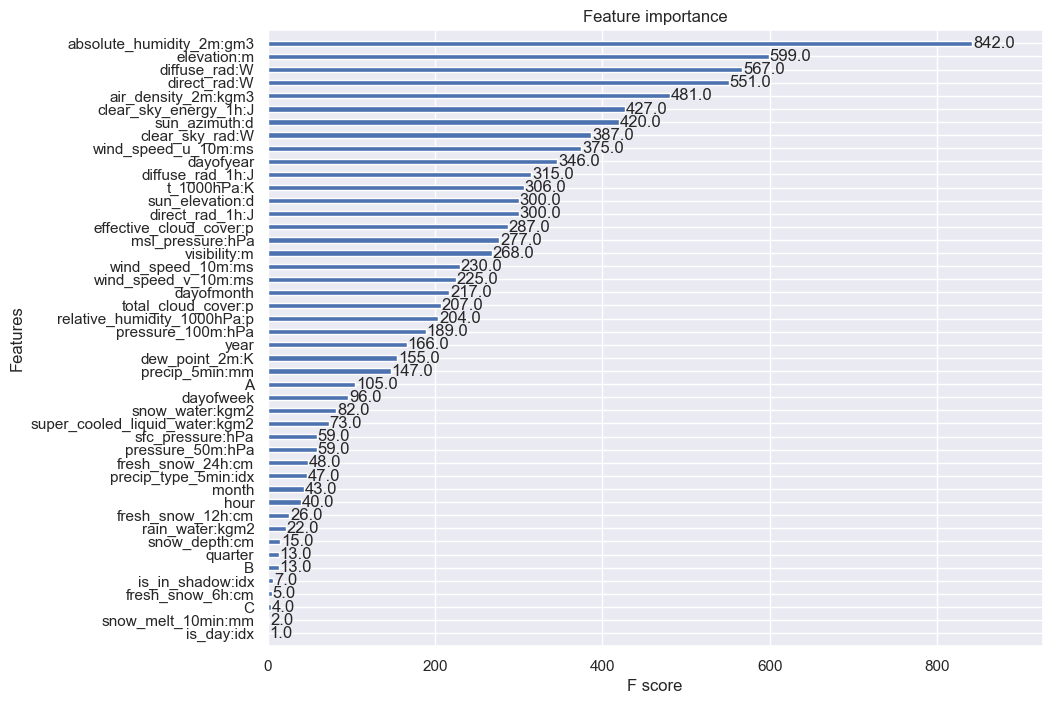

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

xgb.plot_importance(model, height=0.4, ax=ax)